In [2]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pydicom as pdc
import cv2 as cv
from skimage.morphology import skeletonize
from skimage import exposure
from scipy import ndimage
import shutil
import math
import warnings
warnings.filterwarnings('ignore', '.*output shape of zoom.*')
from PIL import Image

# ======

def img_show(img_mtx, figsize=(12,12)):
    plt.figure(figsize=figsize)
    plt.imshow(img_mtx, cmap='gray')
    plt.axis('off')
    plt.show()  
    
# ======

# === SubFunction ===

def edge_detect(img):   
    canny = cv.Canny(img, 0, 1)
    kernel = np.ones((2,2), np.uint8)
    edge = cv.dilate(canny, kernel, iterations = 1)
    x,y,w,h = cv.boundingRect(edge)
    
    return edge,x,y,w,h

# ======

# === SubFunction ===

def cal_porosity(img_mask, img):   
    pixels_all = np.count_nonzero(img_mask>0)
    pixels_white = np.count_nonzero(img>0)
    porosity = (pixels_all-pixels_white)/pixels_all 
    
    return porosity

# ======

def dcm_to_img(file_src_path, output_dir):
    ds = pdc.dcmread(file_src_path)
    image = ds.pixel_array.reshape(ds.pixel_array.shape[0],ds.pixel_array.shape[1]) 
    image[np.where(image == -2000)] = 0
    pixel_scaled_img = np.maximum(image, 0)/np.max(np.abs(image))
    pixel_scaled_img = (255*pixel_scaled_img).astype(np.uint16)
    img = exposure.equalize_adapthist(pixel_scaled_img)
    img = (255*img).astype(np.uint16)

    x = cv.Sobel(image,cv.CV_16S,1,0)
    y = cv.Sobel(image,cv.CV_16S,0,1)

    absX = cv.convertScaleAbs(x)
    absY = cv.convertScaleAbs(y)

    dst = cv.addWeighted(absX, 0.5, absY, 0.5, 0)

    blur = cv.GaussianBlur(dst, (39, 39), 0)
    _, thresh_mask = cv.threshold(blur,200,1,cv.THRESH_BINARY)

    masked_img = img.copy()
    masked_img[np.where(thresh_mask == 0)] = 0 
    
    return thresh_mask, masked_img

def skeletionize_img(thresh_mask, masked_img):
    
    filter = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    sharpen_img = cv.filter2D(masked_img,-1,filter)      
    _, sharpen_thresh = cv.threshold(sharpen_img ,np.mean(sharpen_img),1,cv.THRESH_BINARY)

    skeleton = (255*skeletonize(sharpen_thresh)).astype(np.uint8)
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3,3))
    skeleton_dilated = cv.morphologyEx(skeleton, cv.MORPH_DILATE, kernel)

    kernel = np.ones((2,2), np.uint8)
    erosion = cv.erode(skeleton_dilated , kernel, iterations = 1) 

    edge,x,y,w,h = edge_detect(thresh_mask)
    porosity = cal_porosity(thresh_mask, erosion)
    print(porosity)

    if porosity<0.4:
        kernel = np.ones((3,3), np.uint8)
        sharpen_erosion = cv.erode(sharpen_thresh , kernel, iterations = 1) 
        sharpen_erosion = (255*sharpen_erosion).astype(np.uint8)

        dst = cv.addWeighted(skeleton, 0.5, sharpen_erosion, 0.5, 0)
        _, thresh = cv.threshold(dst ,np.mean(dst),1,cv.THRESH_BINARY)
        
        img_skeletionize = thresh
        porosity = cal_porosity(thresh_mask, img_skeletionize)   
        
    else:
        img_skeletionize = erosion

    return img_skeletionize, edge, porosity

def rescaled_img(img, img_mask, rescale_num):
    
    height, width = img_mask.shape
    wi = (width/2)
    he = (height/2)

    M = cv.moments(img_mask)

    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])

    offsetX = (wi-cX)
    offsetY = (he-cY)

    T = np.float32([[1, 0, offsetX], [0, 1, offsetY]]) 
    centered_img = cv.warpAffine(img, T, (width, height))
    centered_mask = cv.warpAffine(img_mask, T, (width, height))

    rescale_img = ndimage.zoom(centered_img, rescale_num, order=1, mode='nearest', cval=0.0)  
    rescale_mask = ndimage.zoom(centered_mask, rescale_num, order=1, mode='nearest', cval=0.0)   
    
    return rescale_img, rescale_mask

# ======

def cropped_img(rescale_img, rescale_mask, new_size):

    edge,x,y,w,h = edge_detect(rescale_mask)
    # img_rect = cv.rectangle(edge,(x,y),(x+w,y+h),(255,255,255),2)

    center_width, center_height = (x+x+w)/2, (y+y+h)/2

    rescale_image = Image.fromarray(rescale_img,'L')   
    output_image = rescale_image.crop((center_width-int(new_size), center_height-int(new_size), 
                                       center_width+int(new_size), center_height+int(new_size))
                                     )             
    crop_img = np.array(output_image,np.uint8) 
        
    if rescale_num <= 1:
        _, thresh_crop = cv.threshold(crop_img,np.mean(crop_img)+int(rescale_num*100),1,cv.THRESH_BINARY)
        crop_erosion = thresh_crop
    elif rescale_num == 1:
        _, thresh_crop = cv.threshold(crop_img,np.mean(crop_img),1,cv.THRESH_BINARY)
        crop_erosion = thresh_crop
    else:
        _, thresh_crop = cv.threshold(crop_img,np.mean(crop_img),1,cv.THRESH_BINARY)
        kernel = np.ones((2,2), np.uint8)
        crop_erosion = cv.erode(thresh_crop , kernel, iterations = 1) 

    return crop_erosion

# ======

def cropped_mask(rescale_mask, new_size):
    
    edge,x,y,w,h = edge_detect(rescale_mask)
    
    center_width, center_height = (x+x+w)/2, (y+y+h)/2
    
    rescale_image = Image.fromarray(rescale_mask,'L')   
    output_image = rescale_image.crop((center_width-int(new_size), center_height-int(new_size), 
                                       center_width+int(new_size), center_height+int(new_size))
                                     )             
    crop_img = np.array(output_image,np.uint8)   
    _, thresh_crop = cv.threshold(crop_img,np.mean(crop_img),1,cv.THRESH_BINARY)
    crop_mask = thresh_crop    
    
    return crop_mask
    

In [3]:
# ======

"""Get the width and height of the terminal window.
"""

width, height = shutil.get_terminal_size((80, 20))

# ======

# ======

"""
    :param work_dir (str) : Current working directory
    :param main_dir (str) : Always be set to ./SuperBone_ver1
    :param output_dir (str) : The default directory where all outputs are stored
"""  

work_dir = os.getcwd()
main_dir = os.path.dirname(work_dir)
initial_dir = os.path.join(os.path.dirname(main_dir),'dcm_src')   
output_dir = os.path.join(main_dir,'test')

# ======

import FileChooser

"""Initialize the class and set the initial directory, file type, and the type of file/folder to choose

    :param initial_dir (str) : Initial directory to open the file dialog
    :param file_type (str) : The type of file to select (e.g. "Image", "DICOM",...)
    :param choose_type (str) : The type of file/folder to select ("File", "Folder", "Multiple Files")
"""  

selector = FileChooser.Selector(initial_dir, file_type = "DICOM", choose_type = "File")

# ======

"""Open a file dialog windows and return the source path

    :param file_src_path (str) : The absolute path of the source image

"""

file_src_path = selector.run()

# ======

Import File : D:/dcm_src/Aves/Rheiformes/Rheidae/Rhea_americana-greater_rhea/tibia/RHEA TBT _Se2_Im022.dcm


In [4]:
import pandas as pd

search_csv_path = os.path.join(main_dir,'search_output.csv')
search_csv = pd.read_csv(search_csv_path,sep=',')

filter = (search_csv['Scan Options']=='AXIAL MODE')

search_filter = search_csv.iloc[:,[8]][filter]
search_filter['Pixel Spacing (mm)'] = pd.to_numeric(search_filter['Pixel Spacing (mm)'], downcast="float")

mean_pixel_spacing = search_filter['Pixel Spacing (mm)'].quantile(0.5)

ratio = 0.35/0.21875

print(round(mean_pixel_spacing,2))
print(ratio)

0.35
1.5999999999999999


0.5955146175410493
file saved : D:\SuperBone_ver1.20_copy\test\test_sketeton_1.6.png
file saved : D:\SuperBone_ver1.20_copy\test\test_sketeton_edge_1.6.png
file saved : D:\SuperBone_ver1.20_copy\test\test_sketeton_mask_1.6.png


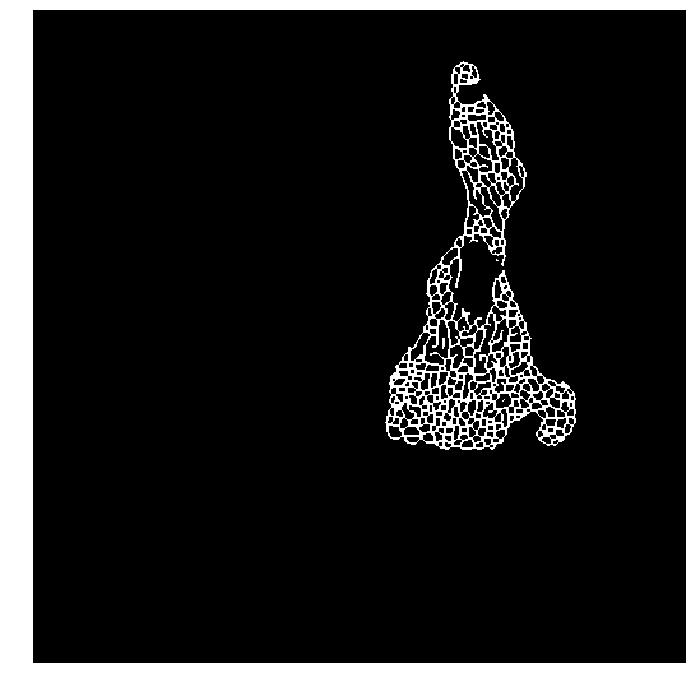

In [6]:
rescale_array = [ratio]
new_size = 510

thresh_mask, masked_img = dcm_to_img(file_src_path, output_dir)
img_skeletionize, edge, porosity = skeletionize_img(thresh_mask, masked_img)
for rescale_num in rescale_array:
    rescale_img, rescale_mask = rescaled_img(img_skeletionize, thresh_mask, rescale_num)
    crop_erosion = cropped_img(rescale_img, rescale_mask, new_size)
    
    save_path = os.path.join(output_dir,'test_sketeton_{}.png'.format(round(rescale_num,3)))
    plt.imsave(save_path, crop_erosion, cmap='gray')
    print('file saved : {}'.format(save_path))
    
    rescale_img_edge, rescale_mask = rescaled_img(edge, thresh_mask, rescale_num)
    crop_erosion_edge = cropped_img(rescale_img_edge, rescale_mask, new_size)
    
    save_path = os.path.join(output_dir,'test_sketeton_edge_{}.png'.format(round(rescale_num,3)))
    plt.imsave(save_path, crop_erosion_edge, cmap='gray')
    print('file saved : {}'.format(save_path))    
    
    crop_mask = cropped_mask(rescale_mask, new_size)  
    
    save_path = os.path.join(output_dir,'test_sketeton_mask_{}.png'.format(round(rescale_num,3)))
    plt.imsave(save_path, crop_mask, cmap='gray')
    print('file saved : {}'.format(save_path))     
    
    
img_show(img_skeletionize)

In [ ]:
    '''
    new_porosity = cal_porosity(rescale_mask, thresh_crop)
    
    if abs((porosity-new_porosity)/porosity) < 0.1: 
        kernal_size = 1
        crop_erosion = thresh_crop     
    elif porosity-new_porosity>0:    
        for kernal_size in range(6,0,-1):
            if abs((porosity-new_porosity)/porosity) < 0.1: 
                break
            else:
                kernel = np.ones((kernal_size,kernal_size), np.uint8)
                crop_erosion = cv.erode(thresh_crop , kernel, iterations = 1) 
                new_porosity = cal_porosity(rescale_mask, crop_erosion)
    elif porosity-new_porosity<0:    
        for kernal_size in range(1,6,1):
            if abs((porosity-new_porosity)/porosity) < 0.1: 
                break
            else:
                kernel = np.ones((kernal_size,kernal_size), np.uint8)
                crop_erosion = cv.dilate(thresh_crop , kernel, iterations = 1) 
                new_porosity = cal_porosity(rescale_mask, crop_erosion)             
    print(kernal_size, new_porosity)
    '''